# Finetuning with Trainer and text-classification model validation

In [74]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
   colab = True
else:
   colab = False

if colab:
    !pip install transformers[torch]
    !pip install accelerate -U
    !pip install datasets
    !pip install torchinfo
    #ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U

In [75]:
from sklearn.model_selection import train_test_split
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import pathlib
import seaborn as sn
import torch
import numbers

from tqdm.autonotebook import tqdm
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from torchinfo import summary
from transformers import AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments, DataCollatorWithPadding, AutoTokenizer, pipeline
from transformers.modelcard import parse_log_history

# Prepare parameters for each run of finetuning

In [76]:
# from huggingface_hub import notebook_login
# notebook_login()

In [77]:
# models = ['albert', 'bart', 'bert', 'big_bird', 'bigbird_pegasus', 'biogpt', 'bloom', 'camembert', 'canine', 'code_llama', 'convbert', 'ctrl', 'data2vec-text', 'deberta', 'deberta-v2', 'distilbert', 'electra', 'ernie', 'ernie_m', 'esm', 'falcon', 'flaubert', 'fnet', 'funnel', 'gemma', 'gpt-sw3', 'gpt2', 'gpt_bigcode', 'gpt_neo', 'gpt_neox', 'gptj', 'ibert', 'layoutlm', 'layoutlmv2', 'layoutlmv3', 'led', 'lilt', 'llama', 'longformer', 'luke', 'markuplm', 'mbart', 'mega', 'megatron-bert', 'mistral', 'mixtral', 'mobilebert', 'mpnet', 'mpt', 'mra', 'mt5', 'mvp', 'nezha', 'nystromformer', 'open-llama', 'openai-gpt', 'opt', 'perceiver', 'persimmon', 'phi', 'plbart', 'qdqbert', 'qwen2', 'reformer', 'rembert', 'roberta', 'roberta-prelayernorm', 'roc_bert', 'roformer', 'squeezebert', 'stablelm', 'starcoder2', 't5', 'tapas', 'transfo-xl', 'umt5', 'xlm', 'xlm-roberta', 'xlm-roberta-xl', 'xlnet', 'xmod', 'yoso',]
# =============================================
# tested = 'distilbert-base-cased', 'camembert-base', 'ctrl', 'xlnet-base-cased', 'roberta-base', 'distilroberta-base', 'flaubert/flaubert_base_cased'
# ----------
#too weak pc (cannot be loaded or runs at speeds <1 it/s) = 'albert-xlarge-v1', 't5-11B', 'LongformerForSequenceClassification', 'xlm-roberta-base', 'allenai/longformer-base-4096', 'facebook/bart-large',  flaubert/flaubert_large_cased (stopped at 0.5 epoch), 
# ----------
# need changes to run (check error logs) =  ProsusAI/finbert (despite adding padding proposed in error)
# =============================================
# model_path = 'SamLowe/roberta-base-go_emotions'
# model_path = 'distilbert-base-uncased'
# model_path = 'xlmoberta'

# , 'camembert-base', 'ctrl', 'xlnet-base-cased', 'roberta-base', 'distilroberta-base', 'flaubert/flaubert_base_cased'

# deprecated: transfo-xl-wt103


#if list of objects is provided list of all combinations of parameters will be created for running
params_tested = {'model': ['michellejieli/emotion_text_classifier'],
                 'num_train_epochs': 10,
                 'save_strategy': 'epoch', # 'epoch'/'no'
                 'per_device_train_batch_size': 8,
                 'per_device_eval_batch_size': 64,
                 'split': [(80, 10, 10)], #may be tuple of len 2/3, dividing respectively into 2:{train, test} and 3:{train, test, validate}. By default labels are stratified. You may pass "balanced" instead of the last element, number of labels for each class will be   
                 'binary': False
                 }

save_logs = True
skip_finetuning = False

def ratio_split_tuple(split):
    split_s = sum([i for i in split if isinstance(i, numbers.Integral)])
    new_split = tuple([i/split_s if isinstance(i, numbers.Integral) else i for i in split])
    return new_split

if isinstance(params_tested['split'], list):
    params_tested['split'] = list(map(ratio_split_tuple, params_tested['split']))
else:
    params_tested['split'] = ratio_split_tuple(params_tested['split'])

params_tested={i:[q] if type(q) is not list else q for (i,q) in params_tested.items()}
keys = list(params_tested.keys())
combinations = list(itertools.product(*params_tested.values()))
result = [{keys[i]: combination[i] for i in range(len(keys))} for combination in combinations]
print(*result, sep='\n')

train_params_looped = result

{'model': 'michellejieli/emotion_text_classifier', 'num_train_epochs': 10, 'save_strategy': 'epoch', 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 64, 'split': (0.8, 0.1, 0.1), 'binary': False}


## Functions

In [83]:
# Prepare functions

def df_to_ds(run_df, run_split):
    
    target_map = {k:i for i,k in enumerate(df['label'].unique())}
    reversed_target_map = {v:k for k, v in target_map.items()}

    run_df['label'] = run_df['label'].map(target_map)
    
    if run_split[-1]=='balanced' or len(run_split)==2:
        if run_split[-1]=='balanced':
            split = [pd.Series(name='sentence'), pd.Series(name='sentence'), pd.Series(name='label'), pd.Series(name='label')]
            n_for_training = run_df.groupby('label').count()['Source'].min()
            train_percentage = run_df.groupby('label').count()['Source'].apply(lambda x: (run_split[0]*n_for_training)/x).to_dict()
            
            for label_name, group in run_df.groupby('label'):
                split_t = train_test_split(group['sentence'], group['label'], test_size=1-train_percentage[label_name], random_state=42, shuffle=True)
                split = [pd.concat([i[0],i[1]], axis=0) for i in zip(split, split_t)]
        else:
            split = train_test_split(run_df['sentence'], run_df['label'], stratify=run_df['label'], test_size=run_split[1], random_state=42, shuffle=True)
        ds = DatasetDict()
        ds['train'] = Dataset.from_pandas(pd.concat([split[0], split[2]], axis=1))
        ds['test'] = Dataset.from_pandas(pd.concat([split[1], split[3]], axis=1))
    elif len(run_split)==3:
        non_train_size = 1-run_split[0]
        split = train_test_split(run_df['sentence'], run_df['label'], stratify=run_df['label'], test_size=non_train_size, random_state=42, shuffle=True)
        split2 = train_test_split(run_df['sentence'], run_df['label'], stratify=run_df['label'], test_size=run_split[2]/non_train_size, random_state=42, shuffle=True)
        ds = DatasetDict()
        ds['train'] = Dataset.from_pandas(pd.concat([split[0], split[2]], axis=1))
        ds['test'] = Dataset.from_pandas(pd.concat([split2[0], split2[2]], axis=1))
        ds['validate'] = Dataset.from_pandas(pd.concat([split2[1], split2[3]], axis=1))
    return ds, target_map, reversed_target_map

# Train functions

def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

def save_logs_from_training_run(trainer, train_params, timestamp, trained_model_path, colab, target_map):
    log_history = parse_log_history(trainer.state.log_history)
    log_df = pd.DataFrame(log_history[1])
    log_df.insert(0, 'model', train_params['model'])
    log_df.insert(0, 'timestamp', timestamp)
    log_df['model_path'] = trained_model_path
    log_df['samples_per_s'] = log_history[0]['train_samples_per_second']
    log_df['steps_per_s'] = log_history[0]['train_steps_per_second']
    log_df['colab'] = colab
    log_df['per_device_train_batch_size'] = train_params['per_device_train_batch_size']
    log_df['per_device_eval_batch_size'] = train_params['per_device_eval_batch_size']
    log_df['split'] = str(train_params['split'])
    log_df['target_map'] = str(target_map)
    log_df['binary'] = train_params['binary']

    float_cols = log_df.select_dtypes(include='float64')
    log_df[float_cols.columns] = float_cols.apply(lambda x: round(x, 3))
    log_df.to_csv('output/training_logs.csv', mode='a', header= not os.path.isfile('output/training_logs.csv'), index=False)
    
def finetune(train_params, ds, target_map, save_logs):
    params_passed = {k: train_params[k] for k in train_params if k not in ['model', 'split', 'binary']}
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    trained_model_path = f'output/models/{train_params['model']}_{timestamp}'
    try:
        def tokenize_fn(batch):
            return tokenizer(batch['sentence'], truncation=True)
        
        #Tokenize dataset
        tokenizer = AutoTokenizer.from_pretrained(train_params['model'], trust_remote_code=True)
        # tokenizer.pad_token = tokenizer.eos_token
        if tokenizer.pad_token is None:
            print('isnone')
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})
            # model.resize_token_embeddings(len(tokenizer))
        tokenized_datasets = ds.map(tokenize_fn, batched=True)

        # data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        
        #Change labels
        config = AutoConfig.from_pretrained(train_params['model'], trust_remote_code=True)
        config.vocab_size = tokenizer.vocab_size
        config.id2label = reversed_target_map
        config.label2id = target_map
        
        #Load model
        model = AutoModelForSequenceClassification.from_pretrained(
            train_params['model'], config=config, ignore_mismatched_sizes=True, trust_remote_code=True)
        
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})
            model.resize_token_embeddings(len(tokenizer))
    
        training_args = TrainingArguments(
          output_dir=f'{trained_model_path}/checkpoints',
          evaluation_strategy='epoch',
          logging_strategy='epoch',
          use_cpu = False,
          **params_passed
        )
    
        trainer = Trainer(
            model,
            training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["test"],
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            # data_collator=data_collator,
        )
        
        trainer.train()
        if save_logs:
            print('123321')
            save_logs_from_training_run(trainer, train_params, timestamp, trained_model_path, colab, target_map)

    except Exception as e:
        print(f'Error: {e}')
        if save_logs:
            err_df = pd.DataFrame([[trained_model_path, str(e)]])
            err_df.to_csv('output/error_logs.csv', mode='a', header= not os.path.isfile('output/error_logs.csv'), index=False)
        

        
def to_binary_classification(x):
    if x in ['Positive', 'Negative']:
        return 'Pathos'
    else:
        return x
    
    
# Validate functions

def validate_from_row(checkpoint_path, df):
    val_row = get_log_for_val(checkpoint_path)
    predicted, val_labels = validate(val_row, df.copy())
    val_metrics(predicted, val_labels)

    return predicted, val_labels

def get_log_for_val(checkpoint_path, sort_col='Step', logs_path='output/training_logs.csv'):
    training_logs = pd.read_csv(logs_path)
    if 'checkpoint-' in checkpoint_path:
        temp_path = checkpoint_path.rsplit('models/', 1)[-1]
        model_path, checkpoint_num = temp_path.rsplit('/checkpoints/checkpoint-')
        row = training_logs[(training_logs['model_path'].apply(lambda x: x.rsplit('models/', 1)[-1] == model_path)) & (training_logs['Step'] == int(checkpoint_num))]
    else:
        row = training_logs[training_logs['model_path'] == checkpoint_path].sort_values(sort_col, ascending=False).head(1)
    return row.iloc[0]

def validate(val_row, run_df):
    if val_row['binary']:
        run_df['label'] = run_df['label'].apply(lambda x: to_binary_classification(x))
    split = tuple(float(i) if i.replace('.','',1).isdigit() else i for i in val_row['split'][1:-1].split(', '))
    ds, target_map, reversed_target_map, = df_to_ds(run_df, split)
    val_sentences = ds['validate']['sentence']
    val_labels = [reversed_target_map[i] for i in ds['validate']['label']]

    classifier = pipeline('text-classification', model=os.path.join(val_row['model_path'], 'checkpoints', f"checkpoint-{val_row['Step']}"), device=0)
    predicted = [i['label'] for i in classifier(val_sentences)]
    return predicted, val_labels

def val_metrics(predicted, val_labels):
    print("acc:", accuracy_score(val_labels, predicted))
    print("f1:", f1_score(val_labels, predicted, average='macro'))

    cm = confusion_matrix(val_labels, predicted, normalize='true')
    plot_cm(cm)

def plot_cm(cm):
    classes = list(target_map.keys())
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

## Run

In [27]:
# Load PolarIs-Pathos to df
# source: https://github.com/kaatkaa/PolarIs-Corpora/blob/main/PolarIs-Full-Corpus/PolarIs-Full-Corpus-Pathos/PolarIs-Pathos.xlsx
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = 'drive/MyDrive/master_lm/PolarIs-Pathos.xlsx'
else:
    data_path = 'data/PolarIs-Pathos.xlsx'

df = pd.read_excel(data_path)
df['label'] = df[['No_pathos', 'Positive', 'Negative']].idxmax(axis=1)
df = df.rename(columns={'Sentence':'sentence'})

#run looped 
for train_params in tqdm(train_params_looped):
    run_df = df.copy()
    if train_params['binary']:
        run_df['label'] = run_df['label'].apply(lambda x: to_binary_classification(x))
    ds, target_map, reversed_target_map, = df_to_ds(run_df, train_params['split'])
    if not skip_finetuning:
        finetune(train_params, ds, target_map,save_logs)

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/12470 [00:00<?, ? examples/s]

Map:   0%|          | 0/7793 [00:00<?, ? examples/s]

Map:   0%|          | 0/7795 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at michellejieli/emotion_text_classifier and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Jakub\DataspellProjects\EQILLM\venv\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None,

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

## Validate

acc: 0.8867222578576011
f1: 0.8325559270992585


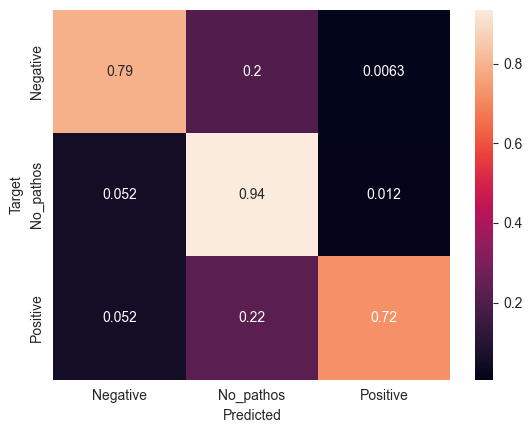

In [93]:
# Load PolarIs-Pathos to df
# source: https://github.com/kaatkaa/PolarIs-Corpora/blob/main/PolarIs-Full-Corpus/PolarIs-Full-Corpus-Pathos/PolarIs-Pathos.xlsx
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = 'drive/MyDrive/master_lm/PolarIs-Pathos.xlsx'
else:
    data_path = 'data/PolarIs-Pathos.xlsx'

df = pd.read_excel(data_path)
df['label'] = df[['No_pathos', 'Positive', 'Negative']].idxmax(axis=1)
df = df.rename(columns={'Sentence':'sentence'})

checkpoint_path = 'output/models/michellejieli/emotion_text_classifier_2024-04-11_09-02/checkpoints/checkpoint-15590'
# checkpoint_path = 'output/models/michellejieli/emotion_text_classifier_2024-04-11_09-02'    
predicted, val_labels = validate_from_row(checkpoint_path, df)

print(f'No_pathos: {len([i for i in predicted if i=='No_pathos'])}/{len([i for i in val_labels if i=='No_pathos'])}')
print(f'Negative: {len([i for i in predicted if i=='Negative'])}/{len([i for i in val_labels if i=='Negative'])}')
print(f'Positive: {len([i for i in predicted if i=='Positive'])}/{len([i for i in val_labels if i=='Positive'])}')

In [94]:
print(f'No_pathos: {len([i for i in predicted if i=='No_pathos'])}/{len([i for i in val_labels if i=='No_pathos'])}')
print(f'Negative: {len([i for i in predicted if i=='Negative'])}/{len([i for i in val_labels if i=='Negative'])}')
print(f'Positive: {len([i for i in predicted if i=='Positive'])}/{len([i for i in val_labels if i=='Positive'])}')

No_pathos: 5479/5319
Negative: 1931/2053
Positive: 385/423
